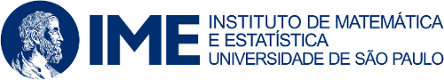

# **MAP2220 - Fundamentos de Análise Numérica**
---
##*Trabalho Computacional 1 - Splines e Interpolação Polinomial*
---
### Aluno: Milton Leal Neto - NUSP: 8973974



Este trabalho consiste na implementação dos Splines Cúbicos com as diversas condições de contorno e Interpolação Polinomial.

**ROTEIRO DO TRABALHO**

**a)** Construa uma função que resolva um sistema linear tri-diagonal conforme descrito no Algoritmo
6.7 de Burden & Faires.

**b)** Utilizando a função do item a) construa uma função que implemente os splines naturais de acordo
com o Algoritmo 3.4.

**c)** Idem para os splines fixos (clamped splines) de acordo com o Algoritmo 3.5

**d)** Os códigos acima devem ser testados nos dois exemplos apresentados nos slides em sala de aula, do texto Burden & Faires (Illustration “ruddy duck in flight” & Exercise 32 “noble beast”). A entrada do programa deve ser uma tabela de com as coordenadas dos pontos que serão interpolados pelo splines dois exemplos: (1) com a tabela 3.18 para “duck in flight” e (2) com a tabela do Exercício 32 (“snoopy noble beast”. A saída deve imprimir na tela (e no relatório) as tabelas dos coeficientes dos splines e os gráficos correspondentes dos splines para cada exemplo.

**e)** A seguir implemente uma função que faça interpolação polinomial (Lagrange e/ou Newton) sobre os dados de entrada do item d). A saída deve imprimir na tela (e no relatório) os coeficientes dos polinômios interpoladores e gráficos correspondentes.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## a) **Crout Factorization**

O algoritmo 6.7 descrito no livro *Numerical Analysis*, de Burden e Faires, denominado "Crout Factorization", resolve um sistema $Ax=b$ composto por $n × n$ equações lineares cuja matriz de coeficientes é tridiagonal. 

Para isso, realizamos uma decomposição da matriz $A$ em uma matriz triangular inferior $L$ (*lower*) e uma matriz triangular superior $U$ (*upper*).

Este algoritmo requer apenas $(5n - 4)$ multiplicações/divisões e $(3n - 3)$
adições/subtrações. 

Consequentemente, tem uma vantagem computacional considerável sobre os
métodos que não consideram a tridiagonalidade da matriz.

In [2]:
def crout_factorization(n: int, A: np.array([])) -> np.array([]):
    """Resolve um sistema Ax=b, cuja matriz A de coeficientes tridiagonal tem 
    acoplada na última coluna o  vetor "b". Logo, A tem dimensão n x n+1. 
    Retorna um vetor com a solução do sistema. 

    Args:
        n (int): número de linhas da matriz A
        A (np.array([])): matriz de coeficientes tridiagonal com vetor "b". 

    Return:
        np.array([]): vetor com a solução do sistema
    """

    lower = np.zeros((n, n)) # Matriz L (triangular inferior)
    upper = np.identity(n) # Matriz U (triangular superior)
    z = np.zeros([n]) # Vetor auxiliar
    x = np.zeros([n+1]) # Vetor de soluções

    # Montagem e resolução do sistema Lz = b.
    lower[0][0] = A[0][0]
    upper[0][1] = A[0][1]/lower[0][0]
    z[0] = A[0][len(A)]/lower[0][0]

    for i in range(1, n-1):
        lower[i][i-1] = A[i][i-1] # i-ésima linha de L
        lower[i][i] = A[i][i] - lower[i][i-1]*upper[i-1][i]
        upper[i][i+1] = A[i][i+1]/lower[i][i] # (i+1)-ésima coluna de U
        z[i] = (A[i][len(A)] - lower[i][i-1]*z[i-1])/lower[i][i]

    lower[n-1][n-2] = A[n-1][n-2] # n-ésima coluna de L
    lower[n-1][n-1] = A[n-1][n-1] - lower[n-1][n-2]* upper[n-2][n-1]
    z[n-1] = (A[n-1][len(A)] - lower[n-1][n-2]*z[n-2])/lower[n-1][n-1]

    # Resolução do sistema Uc = z.
    x[n-1] = z[n-1]

    for i in range(n-2, -1, -1):
      x[i] = z[i] - upper[i][i+1]*x[i+1]

    return x

##**Splines**

A aproximação polinomial por partes mais comum usa polinômios cúbicos entre
cada par sucessivo de nós e é chamada de spline cúbico. 

Um spline cúbico geral envolve quatro constantes, portanto, há flexibilidade suficiente no procedimento de construção do spline cúbico para garantir que o interpolante não seja apenas continuamente diferenciável no intervalo, mas também tenha uma segunda derivada contínua. 

A construção do spline cúbico, no entanto, não supõe que as derivadas do interpolante coincidam com as da função que está sendo aproximada, até mesmo nos nós. 

## b) **Spline cúbico natural**

Utilizamos o teorema 3.11 do livro de Burden e Faires que discorre sobre a construção do spline cúbico do tipo natural.

<br>

**Teorema 3.11**

Se $f$ está definida em $a = x_0 < x_1 < \cdots < x_n = b$, então a $f$ possui um spline natural interpolante único $S$ nos nós $x_0,x_1,\cdots,x_n$; ou seja, um spline interpolante que satisfaz a condição de contorno natural $S''(a)=0$ e $S'(b)=0$. 

<br>

---
Abaixo, construímos o algoritmo 3.4 do livro do spline cúbico natural, que tem como objetivo a definição dos coeficientes $a_i,b_i,c_i,d_i$ de cada spline cúbico natural interpolador entre os nós da tabela de entrada de dados. 

Assim, o spline cúbico interpolador é da forma:

<br>
$$S_j(x) = a_j + b_j(x-x_j)+c_j(x-x_j)^2+d_j(x-x_j)^3$$
<br>

No algoritmo abaixo, os coeficientes $a_i$ saem de graça ao fazermos $f(x_i) = a_i$. Os outros coeficientes são determinados a partir das relações que definem o spline cúbico natural. 

In [3]:
def natural_cubic_splines(n: int, 
                          xi_points: np.array([]), 
                          ai_points: np.array([])) -> pd.DataFrame:
    """Encontra os coeficientes dos splines cúbicos naturais. 
    Retorna um dataframe com os coeficientes.

    Args:
        n (int): número n de pontos, contado a partir do 0. Portanto, 
                 n = len(dados de entrada) - 1
        xi_points (np.array([])): vetor com os dados de entrada x_i
        ai_points (np.array([])): vetor com os dados observados y_i

    Return:
        pd.DataFrame: objeto do pandas com a tabela de coeficientes
    """

    # Termos x_{j+1} - x_j são muito usados, por isso o definimos como h_i
    h_i = np.array([])
    for i in range(n):
      h_i = np.append(h_i, xi_points[i+1] - xi_points[i])

    # Definimos alpha_i = vetor B do sistema Ax = B
    alpha_i = np.zeros([n+1])
    for i in range(1, n):
        alpha_i[i] = (3/h_i[i] * (ai_points[i+1] - ai_points[i]) 
                    - (3/h_i[i-1]) * (ai_points[i] - ai_points[i-1]))

    # Construção da matriz A que será inputada no algoritmo Crout_Factorization
    A = np.zeros((n+1, n+1))
    A[0][0] = 1
    A[n][n] = 1

    for i in range(1, n):
        A[i][i-1] = h_i[i-1]
        A[i][i] = 2*(h_i[i-1] + h_i[i])
        A[i][i+1] = h_i[i]
    
    # Acoplamos o vetor alpha_i na última coluna da matriz A
    A = np.c_[A, alpha_i]

    # Com a resolução do sistema, obtemos os coeficientes c_i
    c_i = crout_factorization(n, A)
      
    # Cálculo dos coeficientes b_i e d_i
    b_i = np.zeros(n+1)
    d_i = np.zeros(n+1)

    for j in range(n-1, -1, -1):
        b_i[j] = (ai_points[j+1] - ai_points[j])/h_i[j] \
        - (h_i[j]*(c_i[j+1] + 2*c_i[j]))/3
        d_i[j] = (c_i[j+1] - c_i[j])/(3*h_i[j])

    # Criação do DataFrame para exibição dos coeficientes
    df = pd.DataFrame(list(zip(xi_points, ai_points, b_i, c_i, d_i)), 
                      columns=["x_j", "a_i", "b_i", "c_i", "d_i"])
  
    return df

## c) **Spline cúbico fixo**

Utilizamos o teorema 3.12 do livro de Burden e Faires que discorre sobre a construção do spline cúbico do tipo fixo.

<br>

**Teorema 3.12**

Se $f$ está definida em $a = x_0 < x_1 < \cdots < x_n = b$ e é diferenciável em $a$ e $b$, então a $f$ possui um spline fixo interpolante único $S$ nos nós $x_0,x_1,\cdots,x_n$; ou seja, um spline interpolante que satisfaz a condição de contorno fixa $S'(a)=f'(a)$ e $S'(b)=f'(b)$. 

<br>

---
Abaixo, construímos o algoritmo 3.5 do livro do spline cúbico fixo, que tem como objetivo a definição dos coeficientes $a_i,b_i,c_i,d_i$ de cada spline cúbico fixo interpolador entre os nós da tabela de entrada de dados. 

Assim, o spline cúbico interpolador é da forma:

<br>
$$S_j(x) = a_j + b_j(x-x_j)+c_j(x-x_j)^2+d_j(x-x_j)^3$$
<br>

No algoritmo abaixo, os coeficientes $a_i$ saem de graça ao fazermos $f(x_i) = a_i$. Os outros coeficientes são determinados a partir das relações que definem o spline cúbico natural.

In [4]:
def clamped_cubic_splines(n: int, 
                          xi_points: np.array([]), 
                          ai_points: np.array([]), 
                          fpo: float, 
                          fpn: float) -> pd.DataFrame:
    """Encontra os coeficientes dos splines cúbicos fixos. 
    Retorna um dataframe com os coeficientes.

    Args:
        n (int): número n de pontos, contado a partir do 0. Portanto, 
                 n = len(dados de entrada) - 1
        xi_points (np.array([])): vetor com os dados de entrada x_i
        ai_points (np.array([])): vetor com os dados observados y_i
        fpo (float): valor da derivada no ponto x_0
        fpn (float): valor da derivada no ponto x_n

    Return:
        pd.DataFrame: objeto do pandas com a tabela de coeficientes
    """

    # Termos x_{j+1} - x_j são muito usados, por isso o definimos como h_i
    h_i = np.array([])
    for i in range(n):
        h_i = np.append(h_i, xi_points[i+1] - xi_points[i])
      
    # Definimos alpha_i = vetor B do sistema Ax = B
    alpha_i = np.zeros([n+1])
    alpha_i[0] = 3*(ai_points[1] - ai_points[0])/h_i[0] - 3*fpo
    alpha_i[-1] = 3*fpn - 3*(ai_points[-1] - ai_points[-2])/h_i[-1]
    
    for i in range(1, n):
      alpha_i[i] = (3/h_i[i] * (ai_points[i+1] - ai_points[i]) 
                    - (3/h_i[i-1]) * (ai_points[i] - ai_points[i-1]))
    
    # Construção da matriz A que será inputada no algoritmo Crout_Factorization
    A = np.zeros((n+1, n+1))
    A[0][0] = 2*h_i[0]
    A[0][1] = h_i[0]
    A[n][n-1] = h_i[-1]
    A[n][n] = 2*h_i[-1]

    for i in range(1, n):
        A[i][i-1] = h_i[i-1]
        A[i][i] = 2*(h_i[i-1] + h_i[i])
        A[i][i+1] = h_i[i]
    
    # Acoplamos o vetor alpha_i na última coluna da matriz A
    A = np.c_[A, alpha_i]

    # Acoplamos o vetor alpha_i na última coluna da matriz A
    c_i = crout_factorization(n+1, A)
    
    # Cálculo dos coeficientes b_i e d_i
    b_i = np.zeros(n+1)
    d_i = np.zeros(n+1)
    
    for j in range(n-1, -1, -1):
        b_i[j] = (ai_points[j+1] - ai_points[j])/h_i[j] - (h_i[j]*(c_i[j+1] + 2*c_i[j]))/3
        d_i[j] = (c_i[j+1] - c_i[j])/(3*h_i[j])

    # Criação do DataFrame para exibição dos coeficientes
    df = pd.DataFrame(list(zip(xi_points, ai_points, b_i, c_i, d_i)), 
                      columns=["x_j", "a_i", "b_i", "c_i", "d_i"])
  
    return df

## d) **Resultados dos splines**

Como pedido, testamos o spline natural com o conjunto de dados relacionado ao "Pato Voador" e o spline fixo com o conjunto de dados relacionado ao "Snoopy", ambos retirados do livro de Burden e Faires.

Antes disso, definimos algumas funções auxiliares para plotarmos os gráficos. 

In [5]:
def calcula_polinomio(x, coeficientes):
    """Dado um conjunto de coeficientes e um ponto de entrada x, avalia um 
    polinômio cúbico. Retorna o valor do polinômio.

    Args:
        x (np.ndarray([])): vetor de pontos a ser avaliado
        coeficientes (pd.Series): uma linha do DataFrame de coeficientes

    Returns:
        y (np.ndarray([])): vetor de valores do polinômio
    """
    
    y = coeficientes[1] + coeficientes[2]*(x - coeficientes[0]) + coeficientes[3]*(x - coeficientes[0])**2 + coeficientes[4]*(x - coeficientes[0])**3
    
    return y

In [6]:
def plota_grafico(pontos_x: np.array([]), 
                  pontos_y: np.array([]), 
                  df_coeficientes: pd.DataFrame(),
                  titulo: str):
    """Plota os gráficos. 

    Args:
        pontos_x (np.array([])): pontos de x
        pontos_y (np.array([])): valores de f(x)
        df_coeficientes (pd.DataFrame()): tabela com os coeficientes
        titulo (str): título do gráfico

    Returns
        matplotlib object: gráfico solicitado
    """
    
    y = np.array([])
    x = np.array([])

    for i in range(len(pontos_x)-1):
        # obtém coeficientes de cada spline
        coeficientes = df_coeficientes.iloc[i]
        # cria intervalor para avaliar os pontos x
        intervalo_x_menor = np.linspace(pontos_x[i], pontos_x[i+1],10000)
        x = np.append(x, intervalo_x_menor)
        #calcula os pontos x do intervalo no polinômio
        y = np.append(y, calcula_polinomio(intervalo_x_menor, coeficientes))

    fig = plt.figure(figsize = (20,5))
    fig.suptitle(titulo, fontsize = 40)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('f(x)', fontsize=20)
    plt.grid()
    plot = plt.plot(x, y, label = "Splines") and \
    plt.scatter(pontos_x, pontos_y, label = "Pontos tabelados", color = "r")
    plt.legend(fontsize=20)

    return plot

## Resultados do Pato Voador

### *Dados de entrada*

In [7]:
# Dados obtidos no exemplo 3.18 da seção 3.5 do livro de Burden e Faires
x_pato = np.array([0.9, 1.3, 1.9, 2.1, 2.6, 3., 3.9, 4.4, 4.7, 5., 6., 
                   7., 8., 9.2, 10.5, 11.3, 11.6, 12., 12.6, 13., 13.3])
y_pato = np.array([1.3, 1.5, 1.85, 2.1, 2.6, 2.7, 2.4, 2.15, 2.05, 2.1, 2.25, 
                   2.3, 2.25, 1.95, 1.4, 0.9, 0.7, 0.6, 0.5, 0.4, 0.25])

### *Tabela de coeficientes*

In [8]:
df_pato = natural_cubic_splines(len(x_pato)-1, x_pato, y_pato)
df_pato

,x_j,a_i,b_i,c_i,d_i
0,0.9,1.30,0.539624,0.000000,-0.247649
1,1.3,1.50,0.420752,-0.297179,0.946912
2,1.9,1.85,1.086803,1.407263,-2.956382
3,2.1,2.10,1.294942,-0.366567,-0.446635
4,2.6,2.60,0.593399,-1.036519,0.445051
5,3.0,2.70,-0.022191,-0.502457,0.174160
6,3.9,2.40,-0.503406,-0.032226,0.078076
7,4.4,2.15,-0.477075,0.084888,1.314171
8,4.7,2.05,-0.071316,1.267642,-1.581219
9,5.0,2.10,0.262340,-0.155455,0.043115


### *Gráfico*

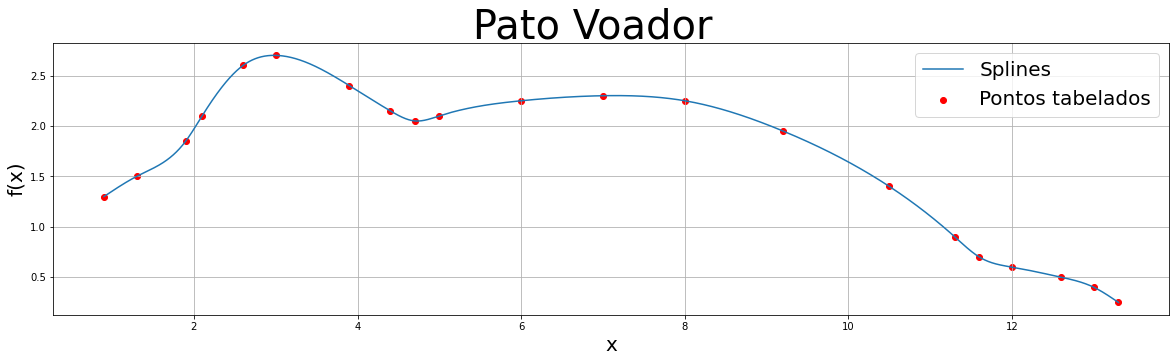

In [9]:
plt.show(plota_grafico(x_pato, y_pato, df_pato, "Pato Voador"))

### *Análise dos Resultados*

Podemos observar no gráfico que a aproximação via Splines Cúbicos Naturais é praticamente idêntica à figura mostrada no livro, o que mostra quão poderoso é este método de interpolação. 

Outro fato interessante é que a curva que aproxima o perfil do Pato Voador passa por todos os pontos que originalmente foram tabelados. 

## Resultados do Snoopy

### *Dados de entrada*

In [10]:
# Dados obtidos no exercício 32 da seção 3.5 do livro de Burden e Faires

# Os dois conjuntos abaixo congregam todos os pontos, sem repetição, que foram 
# disponibilizados em três tabelas distintas. Esse conjunto de dados é utiliza-
# do tanto para o plot do gráfico quanto na seção e) deste trabalho para a rea-
# lização da interpolação de Newton para o exemplo do Snoopy. 
x_snoopy = np.array([1, 2, 5, 6, 7, 8, 10, 13, 17, 20, 23, 
                     24, 25, 27, 27.7, 28, 29, 30])
y_snoopy = np.array([3, 3.7, 3.9, 4.2, 5.7, 6.6, 7.1, 6.7, 4.5, 
                     7, 6.1, 5.6, 5.8, 5.2, 4.1, 4.3, 4.1, 3])

# Dados do primeiro spline cúbico
x_snoopy1 = np.array([1, 2, 5, 6, 7, 8, 10, 13, 17])
y_snoopy1 = np.array([3, 3.7, 3.9, 4.2, 5.7, 6.6, 7.1, 6.7, 4.5])
fpo1 = np.array([1])
fpn1 = np.array([-0.67])

# Dados do segundo spline cúbico
x_snoopy2 = np.array([17, 20, 23, 24, 25, 27, 27.7])
y_snoopy2 = np.array([4.5, 7, 6.1, 5.6, 5.8, 5.2, 4.1])
fpo2 = np.array([3])
fpn2 = np.array([-4])

# Dados do terceiro spline cúbico
x_snoopy3 = np.array([27.7, 28, 29, 30])
y_snoopy3 = np.array([4.1, 4.3, 4.1, 3])
fpo3 = np.array([0.33])
fpn3 = np.array([-1.5])

### *Tabela de coeficientes*

Primeiro Spline

In [11]:
df_snoopy_spline1 = clamped_cubic_splines((len(x_snoopy1)-1), 
                                          x_snoopy1, 
                                          y_snoopy1, 
                                          fpo1, 
                                          fpn1)
df_snoopy_spline1

,x_j,a_i,b_i,c_i,d_i
0,1,3.0,1.000000,-0.346810,0.046810
1,2,3.7,0.446810,-0.206380,0.026555
2,5,3.9,-0.074480,0.032617,0.341863
3,6,4.2,1.016343,1.058205,-0.574548
4,7,5.7,1.409109,-0.665439,0.156329
5,8,6.6,0.547220,-0.196450,0.023920
6,10,7.1,0.048460,-0.052930,-0.002556
7,13,6.7,-0.338131,-0.075934,0.005742
8,17,4.5,0.000000,-0.007033,0.000000


Segundo Spline

In [12]:
df_snoopy_spline2 = clamped_cubic_splines((len(x_snoopy2)-1), 
                                          x_snoopy2, 
                                          y_snoopy2, 
                                          fpo2, 
                                          fpn2)
df_snoopy_spline2

,x_j,a_i,b_i,c_i,d_i
0,17.0,4.5,3.000000,-1.100708,0.126162
1,20.0,7.0,-0.197875,0.034750,-0.022931
2,23.0,6.1,-0.608501,-0.171626,0.280127
3,24.0,5.6,-0.111371,0.668756,-0.357385
4,25.0,5.8,0.153987,-0.403398,0.088202
5,27.0,5.2,-0.401178,0.125815,-2.568002
6,27.7,4.1,0.000000,-5.266989,0.000000


Terceiro Spline

In [13]:
df_snoopy_spline3 = clamped_cubic_splines((len(x_snoopy3)-1), 
                                          x_snoopy3, 
                                          y_snoopy3, 
                                          fpo3, 
                                          fpn3)
df_snoopy_spline3

,x_j,a_i,b_i,c_i,d_i
0,27.7,4.1,0.330000,2.262046,-3.799413
1,28.0,4.3,0.661386,-1.157426,0.296040
2,29.0,4.1,-0.765347,-0.269307,-0.065347
3,30.0,3.0,0.000000,-0.465347,0.000000


### *Gráfico*

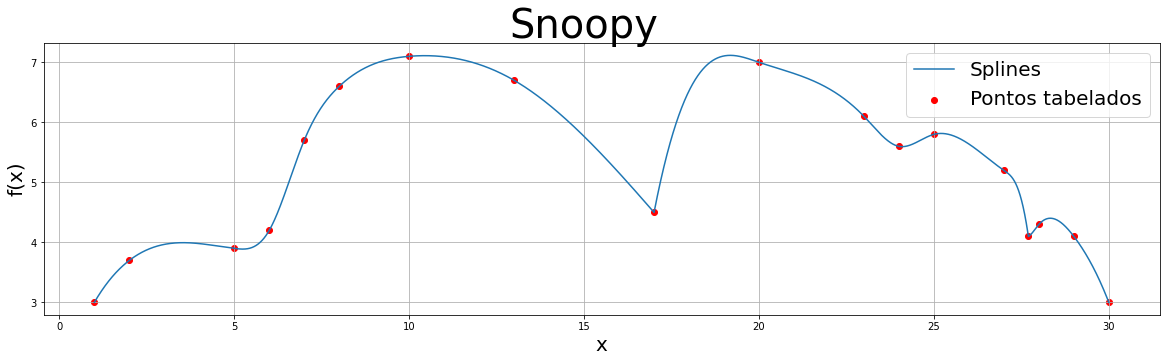

In [14]:
df_concat = pd.concat([df_snoopy_spline1, df_snoopy_spline2, df_snoopy_spline3])
df_snoopy = df_concat.reset_index(drop=True).drop(labels=[8,15], axis=0)
plt.show(plota_grafico(x_snoopy, y_snoopy, df_snoopy, "Snoopy"))

### *Análise dos Resultados*

Podemos observar no gráfico que a aproximação via Splines Cúbicos Fixos é praticamente idêntica à figura mostrada no livro, o que mostra quão poderoso é este método de interpolação. 

Outro fato interessante é que a curva que aproxima o perfil do Pato Voador passa por todos os pontos que originalmente foram tabelados.

Também observamos as duas "quinas" formadas no gráfico, uma perto do ponto x=17 e outra perto de x=27 que mostram claramente a divisão entre os três splines que foram construídos. 

## e) **Interpolação de Newton**

Nesta seção, usamos o método de diferenças divididas de Newton para obter o polinômio interpolador aplicado aos exemplos mostrados anteriormente. 

Salientamos que este trata-se de um método recursivo que consegue aproveitar as contas feitas para os cálculos dos coeficientes anteriores do polinômio, o que aumenta enormemente a eficiência computacional do algoritmo. 


# INTERPOLAÇÃO - NEWTON

In [15]:
def newton_coeficientes(x, y):    
    """Calcula os coeficientes do polinômio. Retorna vetor com os coeficientes.

    Args:

        x (np.array([]): vetor com os pontos x
        y (np.array([]): vetor com os valores de f(x)

    Returns:
        np.array([]): vetor com os coeficientes do polinômio
    """

    q = len(x)
    x = np.copy(x)
    coefs = np.copy(y)

    # Calcula os coeficientes recursivamente
    for k in range(1, q):
        coefs[k:q] = (coefs[k:q] - coefs[k - 1])/(x[k:q] - x[k - 1])
        
    return coefs

In [16]:
def avalia_polinomio_newton(pontos_x, pontos_y, intervalo_x):
    """Avalia o polinômio nos pontos. Retorna vetor com valores de f(x)
    
    Args:
        pontos_x (np.array([])): pontos x
        pontos_y (np.array([])): pontos y
        intervalo_x (np.array([])): range de valores de x a ser avaliado

    Returns:
        np.array([]): valores da f(x)

    """
    coeficientes = newton_coeficientes(pontos_x, pontos_y)
    n = len(pontos_x) - 1  # grau do polinômio
    y = coeficientes[n]
    
    for k in range(1, n + 1):
        y = coeficientes[n - k] + (intervalo_x - pontos_x[n - k])*y

    return y

In [17]:
def plota_grafico_newton(pontos_x, pontos_y, df_coeficientes, titulo):
    """Plota os gráficos. 

    Args:
        pontos_x (np.array([])): pontos de x
        pontos_y (np.array([])): valores de f(x)
        df_coeficientes (pd.DataFrame()): tabela com os coeficientes
        titulo (str): título do gráfico

    Returns
        matplotlib object: gráfico solicitado
    """
    
    y = np.array([])
    x = np.array([])

    for i in range(len(pontos_x)-1):
        coeficientes = df_coeficientes.iloc[i]
        intervalo_x_menor = np.linspace(pontos_x[i], pontos_x[i+1],10000)
        x = np.append(x, intervalo_x_menor)
        y = np.append(y, avalia_polinomio_newton(pontos_x, 
                                                 pontos_y, 
                                                 intervalo_x_menor))

    fig = plt.figure(figsize = (20,5))
    fig.suptitle(titulo, fontsize = 40)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('f(x)', fontsize=20)
    plt.grid()
    plot = plt.plot(x, y, label = "Polinômio de Newton") and \
    plt.scatter(pontos_x, pontos_y, label = "Pontos tabelados", color = "r")
    plt.legend(fontsize=20)

    return plot

# *Exemplo do Pato Voador*

### *Tabela de coeficientes*

In [18]:
df_pato_newton = pd.DataFrame(newton_coeficientes(x_pato, y_pato))
df_pato_newton = df_pato_newton.rename_axis("F[i,i]", axis = 1)
df_pato_newton

"F[i,i]",0
0,1.300000e+00
1,5.000000e-01
2,8.333333e-02
3,6.250000e-01
4,-9.063241e-01
5,5.668351e-01
6,-1.839119e-01
7,3.874691e-02
8,-2.548150e-03
9,-1.858675e-03


### *Gráfico*

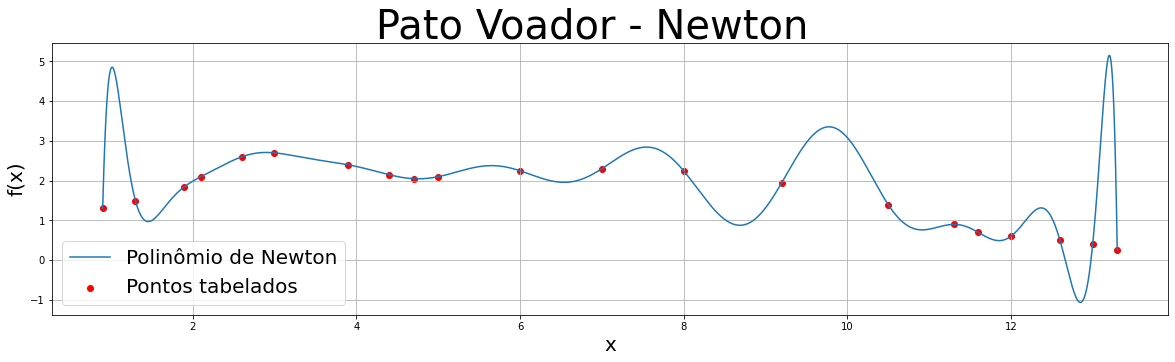

In [19]:
plt.show(plota_grafico_newton(x_pato, y_pato, df_pato_newton, "Pato Voador - Newton"))

### *Análise dos Resultados*

Como era esperado, devido ao alto grau do polinômio, observamos o clássico fenômeno de Runge nas extremidades do polinômio. Ou seja, a aproximação para um polinômio de grau tão elevado não é boa. O correto seria, em um trabalho futuro, fazer o ajuste do grau do polinômio até obtermos algo mais aceitável. 

# *Exemplo do Snoopy*

### *Tabela de coeficientes*

In [20]:
df_snoopy_newton = pd.DataFrame(newton_coeficientes(x_snoopy, y_snoopy))
df_snoopy_newton = df_snoopy_newton.rename_axis("F[i,i]", axis = 1)
df_snoopy_newton

"F[i,i]",0
0,3.000000e+00
1,7.000000e-01
2,-1.583333e-01
3,4.333333e-02
4,1.083333e-02
5,-1.126984e-02
6,3.088624e-03
7,-4.430215e-04
8,3.966125e-05
9,-2.765838e-06


### *Gráfico*

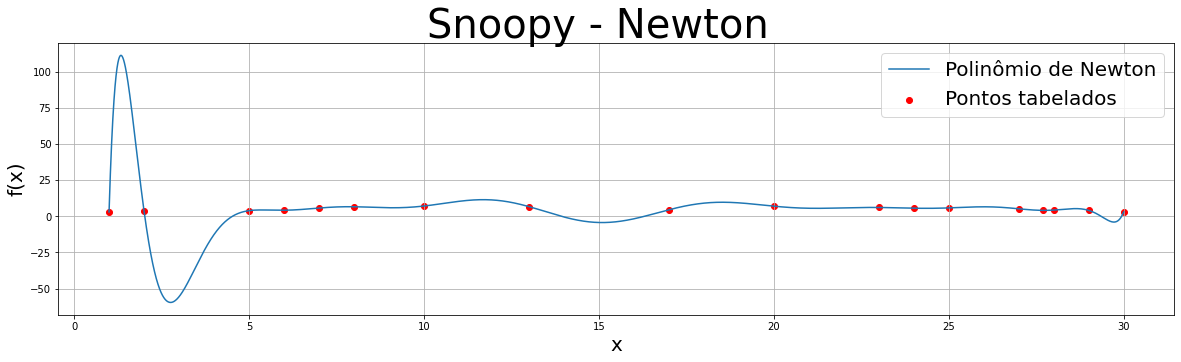

In [21]:
plt.show(plota_grafico_newton(x_snoopy, y_snoopy, df_snoopy_newton, "Snoopy - Newton"))

### *Análise dos Resultados*

Podemos observar que a aproximação polinomial também não foi boa devido ao alto grau do polinômio. Assim como no exemplo anterior, em um trabalho futuro, o correto seria tentarmos realizar um ajuste de grau no polinômio. Vimos durante as aulas que possivelmente com um polinômio de até quinto grau poderíamos obter uma aproximação razoavelmente adequada. 